#  **Project: Digit Recognition with CNN (MNIST)**

**Author:** *Anam Jafar*\
**Date:** *19-09-2025*\
**Dataset Source:** [MNIST Handwritten Digit Database](hhttps://www.kaggle.com/datasets/hojjatk/mnist-dataset/)


## **Overview**

This project aims to build a **Convolutional Neural Network (CNN)** to classify handwritten digits (0–9) from the MNIST dataset.
The MNIST dataset is widely used as a beginner’s benchmark in deep learning and computer vision tasks.



## **Objectives**

1. Understand the structure of the MNIST dataset (images and labels).
2. Preprocess the dataset (normalization, reshaping, encoding).
3. Build a CNN architecture suitable for image classification.
4. Train the model and visualize performance (accuracy & loss curves).
5. Evaluate the model on the test dataset.
6. Analyze results using confusion matrix and sample predictions.

# Step 1 : Data Loading and Exploration

In [ ]:
# importing necessary libraries

import numpy as np
#Used for handling arrays and mathematical operations we use it here to reshaping images, normalizing pixel values, working with labels

import matplotlib.pyplot as plt
#Used for plotting graphs and visualizing data. We use it to display images from MNIST, accuracy/loss curves, and predictions.

import tensorflow as tf
#The deep learning framework powering everything. Provides all the tools to build, train, and evaluate neural networks.

from tensorflow.keras.datasets import mnist
#MNIST is included in Keras datasets so no need to download manually. Provides training and testing data ready to use.

from tensorflow.keras.utils import to_categorical
#Converts labels (like 3) into one-hot encoded vectors ([0,0,0,1,0,0,0,0,0,0]). Required for categorical crossentropy loss.

from tensorflow.keras.models import Sequential
#Simplest way to build models: just stack layers one after another.

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ## CNN layers
# Conv2D: detect features (edges, shapes). MaxPooling2D: reduce size, keep important features. Flatten: convert 2D feature maps into 1D vector. Dense: fully connected layers for decision making. Dropout: randomly turn off neurons to prevent overfitting

from tensorflow.keras import Input, Model
#Functional API: for building custom/complex models We used it temporarily to extract and visualize layer outputs.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion matrix and visualization (to analyze mistakes)

from sklearn.metrics import classification_report
# Helps in evaluating model performance beyond accuracy.

from tensorflow.keras.models import load_model
#let us save the trained model

In [ ]:
 # Set a random seed for reproducibility
 seed = 42
 # Fix NumPy random operation
np.random.seed(seed)

# Fix TensorFlow random operations (e.g., weight initialization)
tf.random.set_seed(seed)

In [ ]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()  #we are loading mnist data directly from TEnsorFlow library . Tensor flow has splitted the dataset in training and testing set

# Print basic info
print("x_train shape:", x_train.shape) #x_train, y_train : it contains training images and labels
print("y_train shape:", y_train.shape)
print("x_test shape :", x_test.shape)    #x_test, y_test : it contains test images and labels
print("y_test shape :", y_test.shape)

print("dtype:", x_train.dtype, " min:", x_train.min(), " max:", x_train.max())  # it will tell us the data type of pixels which is uint8  min: 0  max: 255 means integers b/w 0 and 255 where 0 is pure black and 255 is white

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)
dtype: uint8  min: 0  max: 255


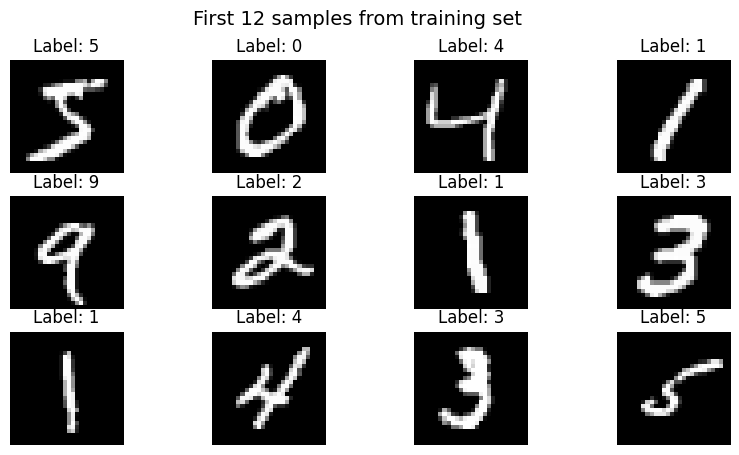

In [ ]:
#show the first 12 images with labels
plt.figure(figsize=(10, 5)) #here we are creating a blank canvas for plotting , figsize=(10, 5) means that the figure will 10 inches wide and 5 inches tall so its look big for 12 images
for i in range(12): #start a loop to display the first 12 images from the training set , i is a temporary variable here which will go from 0 to 11
    plt.subplot(3, 4, i+1) #it will divide the canvas into a grid , 3 rows 4 columns = 12 slots  , i + 1 means from 1st loop iteration it will iterate till 12 slots and each slot will hold one image
    plt.imshow(x_train[i], cmap='gray') # display the ith training image , cmap = gray tells matplotlib to show it in gray  scle not in color
    plt.title(f"Label: {y_train[i]}") #adds a title above each image shwing its true lables(0-9)
    plt.axis('off') #hide the x and y axes(ticks/numbers) so the images look clean
plt.suptitle("First 12 samples from training set", fontsize=14) # Adds one big title at the top of the whole figure, here First 12 samples.....
plt.show()#finally displays everything we prepared

Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples


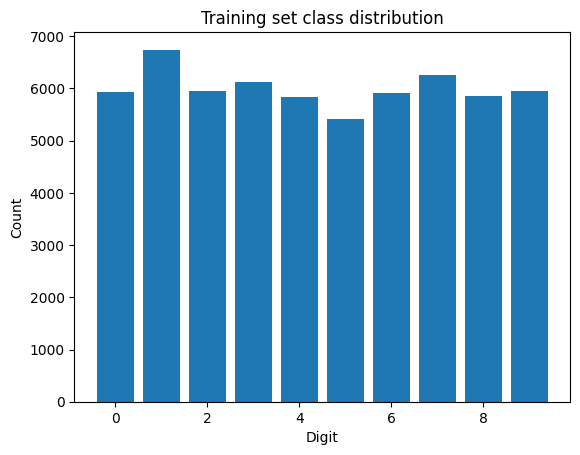

In [ ]:
#check frequency of each label
unique, counts = np.unique(y_train, return_counts=True) # np.unique will find all distint lables in y_train and will return how many times each label appears
for u, c in zip(unique, counts): #u = label, c = count , zip function will pairs each label with its count , like you can see in first result (Digit 0: 5923 samples) here 0 is the digit and 5923 its count mean how many times 0 appers in data
    print(f"Digit {u}: {c} samples") # it will shows the readable line for each digit

# quick bar plot
plt.bar(unique, counts) #draws a bar chart: x = digits, y = counts.
plt.xlabel('Digit') #these are lables
plt.ylabel('Count')
plt.title('Training set class distribution')
plt.show()#displays the chart

Why we need Preprocessing?

- Before training, we must need to prepare the data so the CNN can understand it.

- Raw MNIST images are 28×28 integers between 0–255.
  We need to  reshape them to add a channel dimension so CNN layers can read them.

- We need to normalize pixels to 0–1 so training is faster and more stable.

- We need to convert labels into one-hot vectors so the model can output probabilities for 10 classes.

Without these steps, the model won’t train properly or may give poor results.

# Step 2 : Data Preprocessing

In [ ]:
#create explicit validation split
'''
VALIDATION SET is a small proportion of training data that we keeep aside , it helps us monitor performance during training without touching a test set,
think of it like a mock test before final exam because test set will be used at very final evaluation
'''
val_size = 5000 # we decide to keep 5,000 images a side for validation , we choose it as a standard choice , usallly we took 10-12% data for validation here we chooose 5000 which is 8% of training data .That’s large enough to give a reliable estimate of performance

# take last 5000 from training as validation images and labels
x_val = x_train[-val_size:]
y_val = y_train[-val_size:]

# keep the reamaining 55,000 samples as the real training set
x_train = x_train[:-val_size]
y_train = y_train[:-val_size]

# it will print the new dataset size
print("After split:")
print("x_train:", x_train.shape)
print("x_val  :", x_val.shape)
print("x_test :", x_test.shape)

After split:
x_train: (55000, 28, 28)
x_val  : (5000, 28, 28)
x_test : (10000, 28, 28)


In [ ]:
# reshape to add channel dimension and convert dtype
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') # we are adding channels because CNN expects it , our images are gray scale so channel is 1
x_val   = x_val.reshape(-1, 28, 28, 1).astype('float32')  #.astype will convert the data type from  uint8 to float , because it is needed for neural network
x_test  = x_test.reshape(-1, 28, 28, 1).astype('float32')

print("x_train shape:", x_train.shape, " dtype:", x_train.dtype)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)


x_train shape: (55000, 28, 28, 1)  dtype: float32
x_val shape: (5000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [ ]:
# normalize pixel values
x_train /= 255.0  # we are dividing it by 255 so that it will convert pixels 0-255 to 0.0-1.0
x_val   /= 255.0  #this helps faster convergence and avoids exploiding gradients
x_test  /= 255.0

print("After normalization:")
print("x_train min:", x_train.min(), " max:", x_train.max())
print("x_val min:", x_val.min(), " max:", x_val.max())


After normalization:
x_train min: 0.0  max: 1.0
x_val min: 0.0  max: 1.0


In [ ]:
# one-hot encode labels (for categorical crossentropy)
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("y_train original sample:", y_train[0])
print("y_train one-hot sample:", y_train_cat[0])
print("y_train_cat shape:", y_train_cat.shape)

y_train original sample: 5
y_train one-hot sample: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
y_train_cat shape: (55000, 10)


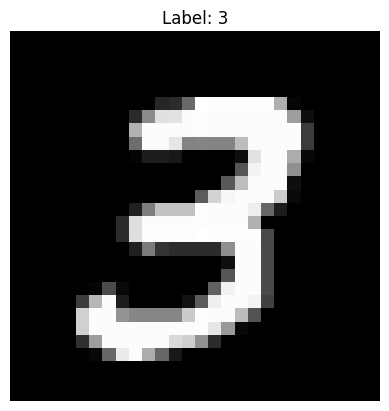

One-hot vector for this sample: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
#show one sample and its one-hot label
idx = 7  # we are displaying one image from training set , here we picked sample at index 7
plt.imshow(x_train[idx].reshape(28,28), cmap='gray') #Display that image again .reshape(28,28) will remove the extra channel dimension (since Matplotlib expects 2D for grayscale).
plt.title(f"Label: {np.argmax(y_train_cat[idx])}") #y_train_cat[idx] is one hot encoder for this image , np.argmax finds the digit label in the vector sp the title shows actual digit like label 3
plt.axis('off') # hides the axes , numbers to show the clean image
plt.show()

print("One-hot vector for this sample:", y_train_cat[idx]) #prints the full one hot encoder for the same image

# Summary of Step 1 and 2

###  Exploration

* **Shapes checked** → Confirmed 60k train, 10k test images, each 28×28.
* **Pixel range** → Values were integers \[0–255], so normalization is needed.
* **Visualization** → Looked at first 12 samples, saw variability in handwriting.
* **Class balance** → Plotted frequency of digits → dataset is balanced.

###  Preprocessing

1. **Validation split** → set aside 5,000 images for validation (train = 55k, val = 5k, test = 10k).
2. **Reshape** → from `(28,28)` → `(28,28,1)` to add channel dimension.
3. **Type cast** → from `uint8` to `float32`, required by TensorFlow.
4. **Normalize** → divide pixels by 255 → values in \[0,1], helps faster training.
5. **One-hot encode labels** → convert labels (e.g., `3`) into 10-length vectors (`[0,0,0,1,0,0,0,0,0,0]`).
6. **Sanity check** → plotted one sample and its one-hot label to confirm correctness.



 **Where we are now:**

* Dataset is **clean, shaped, and ready** for CNN input.
* We’ve ensured **no preprocessing mistakes** by checking outputs at each step.

# Step 3 : Model Architecture

In [ ]:
# Build the CNN model step by step
model = Sequential([

    #  Convolutional layer
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),

    #  Pooling layer
    MaxPooling2D((2,2)),

    #  Another convolutional layer (deeper features)
    Conv2D(64, (3,3), activation='relu'),

    #  Another pooling layer
    MaxPooling2D((2,2)),

    #  Flatten → from 2D feature maps to 1D vector
    Flatten(),

    #  Fully connected layer (dense layer)
    Dense(128, activation='relu'),

    # Dropout → randomly turn off  50% neurons during training
    Dropout(0.5),

    # Output layer 1 neurons for each digit we have 0-9 digits so 10 neurons
    Dense(10, activation='softmax')
])

# Summary
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

# Understanding the each CNN layer Step by step

x_train shape): (55000, 28, 28, 1)
sample shape: (1, 28, 28, 1)


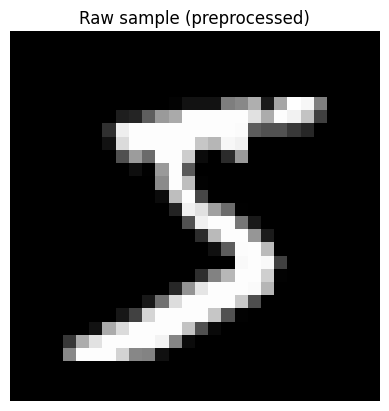

In [ ]:
# pick one sample
print("x_train shape):", x_train.shape)
sample = x_train[:1]   # keep batch size(no. of training samples) 1 to easily inspect activations
''''
in output sample shape is (1, 28, 28, 1) in which 1 is teh batch size, 28 is the height of the pixel, another 28 is the width of the pixel and the last 1 is the no of color (channel)
since this image is gray thatswhy its channel is 1 if its RGB its channel will 3
'''
print("sample shape:", sample.shape)
plt.imshow(sample[0].reshape(28,28), cmap='gray'); plt.title('Raw sample (preprocessed)'); plt.axis('off'); plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Conv1 activation shape: (1, 26, 26, 32)


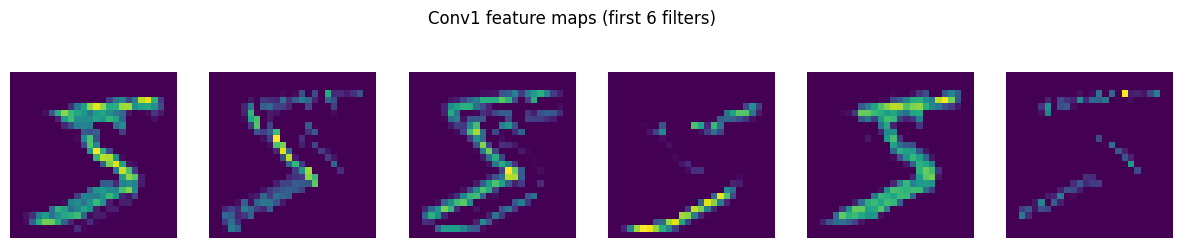

In [ ]:
# single Conv2D layer (This is the CNN’s first step of “seeing” patterns.)

m1 = Sequential([ Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)) ])
m1.summary() # m1 is a small model with just 1 Conv2d layer

act1 = m1.predict(sample)   # runs a forward pass , gives you the activations (outputs) after Conv1. , act1 is just a NumPy array containing the results of the first conv layer
print("Conv1 activation shape:", act1.shape)   # padding='valid'(default) reduces size

'''
in results, none is a batch size , any batch size can go here — when you actually pass 1 sample, it becomes 1 at runtime.

Padding matters. Use padding='same' in Conv2D if you prefer spatial sizes to stay round (28→14→7). Default valid reduces them more (28→26→13→11→5).

Output size = Input size - Filter size + 1
            = 28 - 3 + 1
            = 26

  (None, 26, 26, 32) , 32 means we used 32 filters, so the model produced 32 feature maps. 32 different filtered views of the same 28×28 image
'''
# Why Parameters = 320?

'''

Each filter has weights + bias. Let’s calculate:

Filter size = 3×3

Input channels = 1 (grayscale)

So weights per filter = 3×3×1 = 9

Each filter also has 1 bias → total = 9+1 = 10 parameters per filter.

Number of filters = 32

Total parameters = 10 × 32 = 320

'''

# visualize first 6 feature maps
fig, axs = plt.subplots(1,6, figsize=(15,3))
for i in range(6):
    axs[i].imshow(act1[0,:,:,i], cmap='viridis')
    axs[i].axis('off')
plt.suptitle('Conv1 feature maps (first 6 filters)')
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
After Conv1 + Pool shape: (1, 13, 13, 32)


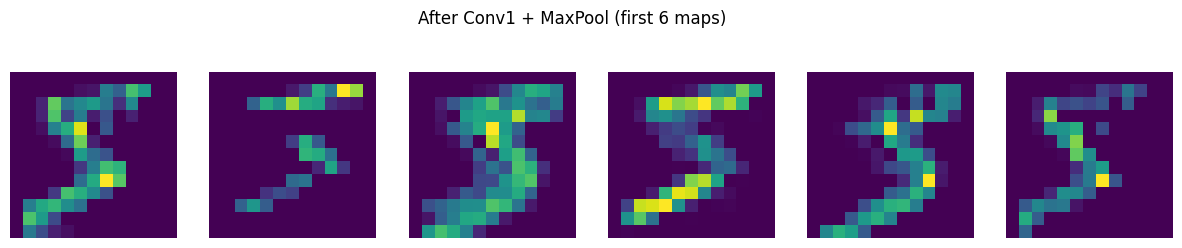

In [ ]:
# add MaxPooling (pooling halves spatial dimensions (13×13 from 26×26))
m2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)) #Pooling “zooms out” and keeps the strongest signals only
])

'''
What is the 2×2 window?

Pooling means “downsampling.”

A 2×2 window slides across the feature map.

From those 4 numbers in the window, it keeps only the maximum.

Example:
[2, 5]
[7, 1]

max = 7 → output cell = 7.

'''
m2.summary()

act2 = m2.predict(sample)
print("After Conv1 + Pool shape:", act2.shape)   # e.g. (1,13,13,32) if valid conv
fig, axs = plt.subplots(1,6, figsize=(15,3))
for i in range(6):
    axs[i].imshow(act2[0,:,:,i], cmap='viridis')
    axs[i].axis('off')
plt.suptitle('After Conv1 + MaxPool (first 6 maps)')
plt.show()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
After Conv2 shape: (1, 11, 11, 64)


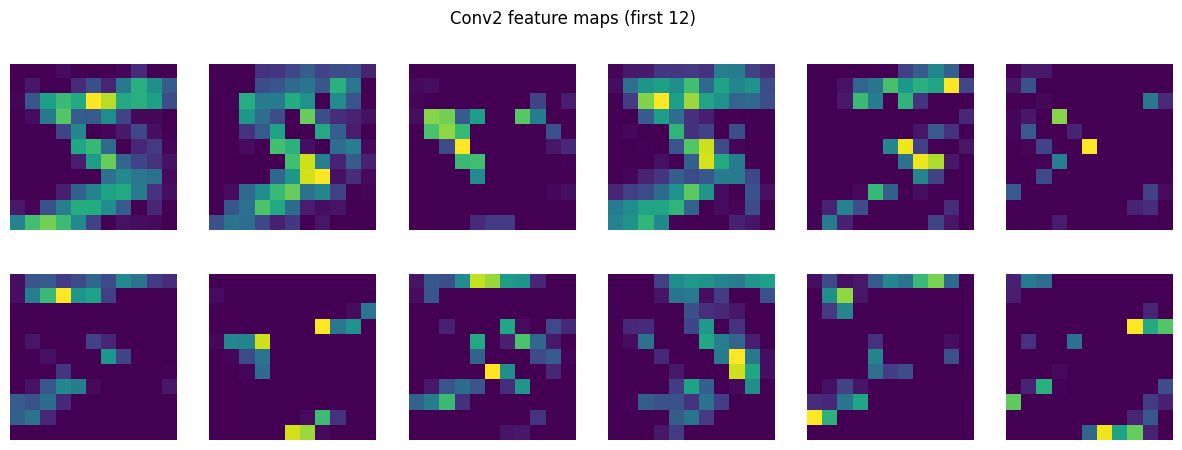

In [ ]:
# Conv -> Pool -> Conv (second conv) . second conv uses 64 filters → captures more complex patterns
m3 = Sequential([
    Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3), activation='relu')
])
m3.summary()

act3 = m3.predict(sample)
print("After Conv2 shape:", act3.shape)   # e.g. (1,11,11,64) if using valid padding
# plot first 12 feature maps of Conv2
fig, axs = plt.subplots(2,6, figsize=(15,5))
for i in range(12):
    axs[i//6, i%6].imshow(act3[0,:,:,i], cmap='viridis')
    axs[i//6, i%6].axis('off')
plt.suptitle('Conv2 feature maps (first 12)')
plt.show()

In [ ]:
# Conv -> Pool -> Conv -> Pool -> Flatten
m4 = Sequential([
    Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten()
])
m4.summary()

flat = m4.predict(sample)
print("After 2 conv+pool then Flatten, shape:", flat.shape)   # e.g. (1, 1600) if valid padding -> 5*5*64=1600

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,816 (73.50 KB)

 Trainable params: 18,816 (73.50 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
After 2 conv+pool then Flatten, shape: (1, 1600)


In [ ]:
# build a small inspect model that outputs Dense(128), Dropout, and final softmax
inp = Input(shape=(28,28,1))
x = Conv2D(32,(3,3), activation='relu', padding='same')(inp)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
d128 = Dense(128, activation='relu')(x)  #Dense(128) created a 128-number vector. Each number is a learned “feature strength.”
dropped = Dropout(0.5)(d128) #Dropoutyou saw many values forced to 0. That’s dropout randomly turning neurons off.
soft = Dense(10, activation='softmax')(dropped) # softmax gave you 10 probabilities that sum to 1. One of them (the largest) is the predicted digit.

inspect_model = Model(inputs=inp, outputs=[d128, dropped, soft])
inspect_model.summary()

# Run in training=True to observe dropout effect; training=False shows inference (dropout off)
dense_out, dropout_out_train, soft_out = inspect_model(sample, training=True)
print("Dense(128) shape:", dense_out.shape)
print("Dropout (training=True) shape:", dropout_out_train.shape)
print("Softmax probs shape:", soft_out.shape)
print("Softmax probs:", soft_out.numpy())
# Count zeros introduced by dropout
print("Zeros after dropout (training=True):", np.sum(dropout_out_train.numpy()==0))

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Dense(128) shape: (1, 128)
Dropout (training=True) shape: (1, 128)
Softmax probs shape: (1, 10)
Softmax probs: [[0.09518154 0.10457329 0.09545717 0.09458666 0.09893757 0.07214944
  0.11974955 0.11260165 0.11009968 0.0966635 ]]
Zeros after dropout (training=True): 97


In order to better understand how a Convolutional Neural Network works,
we inspected the output of each layer step by step.  
By running the model layer-by-layer on a sample image, we could **visualize the feature maps**
and observe how the network gradually transforms the input:

- **Conv layers** highlight edges, curves, and simple patterns.  
- **Pooling layers** reduce image size while keeping the most important signals.  
- **Deeper conv layers** detect more complex structures like digit shapes.  
- **Flatten + Dense** convert these features into a decision vector.  
- **Dropout** shows how some neurons are randomly disabled during training to prevent overfitting.  
- **Softmax output** finally gives probabilities for each digit.  

This process helps us gain intuition about what each layer is doing,
instead of treating the CNN as a “black box.”


# Step 4: Model Compilation

In [ ]:
# Compile the model
model.compile(
    optimizer='adam', # optimizer is how the model improves after ech mistake , Adam is the best optimizer it Combines the best of SGD(It learns from the current mistake) + momentum(Also remembers previous mistakes) + adaptive learning rate (Adjusts learning speed automatically)
    loss='categorical_crossentropy', #loss is a number that tells how bad the prediction was by comparing the prediction to the correct answer , we have multi class classification so  we use categorical crossentropy
    metrics=['accuracy'] # accuracy is the % of correct predictions it is good for balances dataset
)

# Step 5: Train the Model

In [ ]:
history = model.fit(
    x_train, y_train_cat,      # training data
    epochs=10,                 # how many times to go over the training set
    batch_size=128,            # how many samples at a time
    validation_data=(x_val, y_val_cat),  # check performance on validation set
    verbose=2                  # how much detail to show while training
)


Epoch 1/10
430/430 - 9s - 22ms/step - accuracy: 0.9004 - loss: 0.3295 - val_accuracy: 0.9842 - val_loss: 0.0557
Epoch 2/10
430/430 - 2s - 4ms/step - accuracy: 0.9705 - loss: 0.0980 - val_accuracy: 0.9894 - val_loss: 0.0420
Epoch 3/10
430/430 - 2s - 6ms/step - accuracy: 0.9783 - loss: 0.0713 - val_accuracy: 0.9900 - val_loss: 0.0358
Epoch 4/10
430/430 - 3s - 7ms/step - accuracy: 0.9837 - loss: 0.0550 - val_accuracy: 0.9924 - val_loss: 0.0321
Epoch 5/10
430/430 - 2s - 5ms/step - accuracy: 0.9850 - loss: 0.0472 - val_accuracy: 0.9924 - val_loss: 0.0310
Epoch 6/10
430/430 - 2s - 4ms/step - accuracy: 0.9874 - loss: 0.0414 - val_accuracy: 0.9894 - val_loss: 0.0340
Epoch 7/10
430/430 - 3s - 6ms/step - accuracy: 0.9887 - loss: 0.0367 - val_accuracy: 0.9928 - val_loss: 0.0298
Epoch 8/10
430/430 - 3s - 6ms/step - accuracy: 0.9897 - loss: 0.0318 - val_accuracy: 0.9920 - val_loss: 0.0308
Epoch 9/10
430/430 - 3s - 7ms/step - accuracy: 0.9911 - loss: 0.0285 - val_accuracy: 0.9916 - val_loss: 0.0337


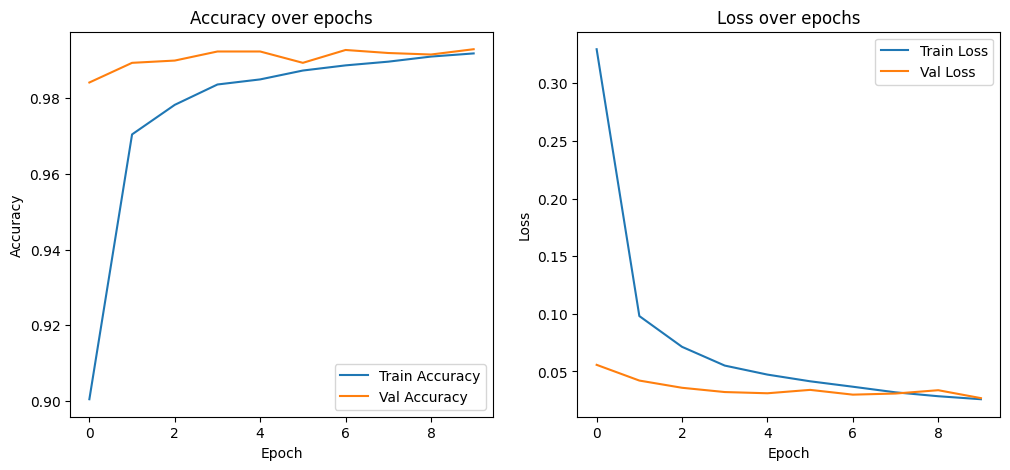

In [ ]:
# Plot training vs validation accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

###  Training Curves Interpretation

The training and validation curves show that our CNN is learning effectively:

- **Accuracy**: Both training and validation accuracy quickly rise and stabilize around ~99%.  
- **Loss**: Both training and validation loss decrease sharply and remain very low.  
- **Gap between curves**: Training and validation performance are very close, indicating **no major overfitting**.  

Overall, the model generalizes well to unseen data and achieves excellent performance on the MNIST dataset.

# Step 6: Evaluate the model

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 99.26%
Test Loss: 0.0213


In [ ]:
# making predictions on first 10 test images
pred_probs = model.predict(x_test[:10])
pred_labels = np.argmax(pred_probs, axis=1)

print("Predicted labels:", pred_labels)
print("True labels     :", y_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Predicted labels: [7 2 1 0 4 1 4 9 5 9]
True labels     : [7 2 1 0 4 1 4 9 5 9]


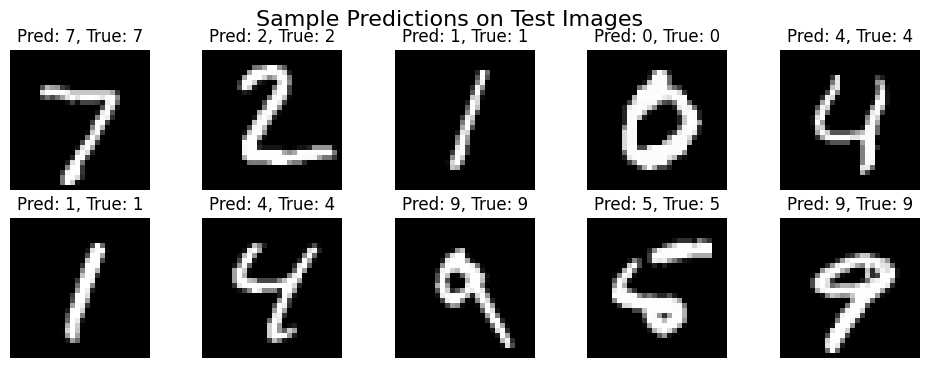

In [ ]:
# visualize predictions (correct vs wrong)
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title(f"Pred: {pred_labels[i]}, True: {y_test[i]}")
    plt.axis('off')
plt.suptitle("Sample Predictions on Test Images", fontsize=16)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


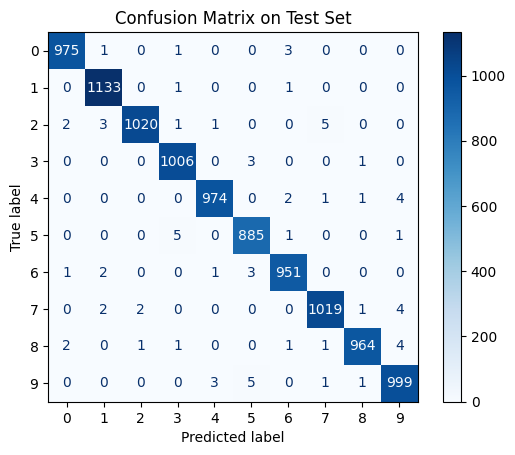

              precision    recall  f1-score   support

           0     0.9949    0.9949    0.9949       980
           1     0.9930    0.9982    0.9956      1135
           2     0.9971    0.9884    0.9927      1032
           3     0.9911    0.9960    0.9936      1010
           4     0.9949    0.9919    0.9934       982
           5     0.9877    0.9922    0.9899       892
           6     0.9917    0.9927    0.9922       958
           7     0.9922    0.9912    0.9917      1028
           8     0.9959    0.9897    0.9928       974
           9     0.9872    0.9901    0.9886      1009

    accuracy                         0.9926     10000
   macro avg     0.9926    0.9925    0.9925     10000
weighted avg     0.9926    0.9926    0.9926     10000



In [ ]:
# plotting confusion matrix
# Predict labels for the entire test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()



# Generate classification report
report = classification_report(y_test, y_pred, digits=4)
print(report)


In [ ]:
# Save the model in HDF5 format
model.save("mnist_cnn.h5")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Load the saved model
loaded_model = load_model("mnist_cnn.h5")

# Check performance to confirm it works
loss, acc = loaded_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Loaded model accuracy: {acc*100:.2f}%")

Loaded model accuracy: 99.26%


##  Conclusion

In this project, we successfully built and trained a Convolutional Neural Network (CNN) on the MNIST handwritten digits dataset.  
Here’s what we achieved and learned:

- **Data exploration** confirmed that the dataset is balanced and consists of grayscale 28×28 images of digits (0–9).  
- **Preprocessing** steps included reshaping, normalization, and one-hot encoding to prepare the data for CNN training.  
- **Model architecture**:  
  - Stacked convolutional and pooling layers to automatically extract features.  
  - Flatten + Dense layers to interpret features and make decisions.  
  - Dropout to prevent overfitting.  
- **Training results**:  
  - Achieved ~99% accuracy on training, validation, and test sets.  
  - Loss curves showed stable learning without overfitting.  
- **Evaluation**:  
  - Confusion matrix revealed only very few misclassifications (mostly between similar-looking digits).  
  - Classification report showed precision, recall, and F1-score close to 0.99 for all classes.  
- **Model saved** in `.h5` format for future use without retraining.

###  Key Learnings
- CNNs can automatically learn patterns from images (edges → shapes → digits).  
- Preprocessing and proper architecture design are critical for performance.  
- Monitoring both training and validation metrics helps detect overfitting/underfitting.  
- Even a relatively simple CNN can achieve state-of-the-art accuracy on MNIST.


## Future Work

Although our CNN performed extremely well on MNIST, there are several ways we could extend or improve this project:

1. **Data Augmentation**  
   - Apply transformations like rotation, shifting, or zooming to create more training examples.  
   - Helps the model generalize better to handwriting variations.

2. **Regularization Techniques**  
   - Try `BatchNormalization` or `L2 regularization` in addition to Dropout.  
   - Can further stabilize training.

3. **Deeper Architectures**  
   - Experiment with more convolutional layers or advanced architectures (e.g., LeNet-5, VGG-like networks).  
   - Compare performance and training time.

4. **Hyperparameter Tuning**  
   - Change learning rate, batch size, number of filters, or dense units.  
   - Use tools like Keras Tuner for automated tuning.

5. **Transfer Learning**  
   - Use a pretrained CNN (e.g., trained on ImageNet) and fine-tune it for MNIST.  
   - Useful for scaling to more complex datasets.

6. **Deployment**  
   - Convert the trained model to TensorFlow Lite or ONNX.  
   - Deploy on mobile or web apps for real-time digit recognition.
.
